# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Check the data

In [2]:
portfolio.shape

(10, 6)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile['gender'].shape

(17000,)

In [6]:
((profile['gender'].isnull())&(profile['income'].isnull())&(profile['age']==118)).sum()

2175

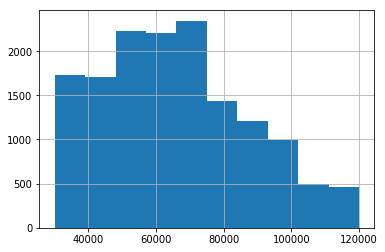

In [7]:
profile['income'].hist()

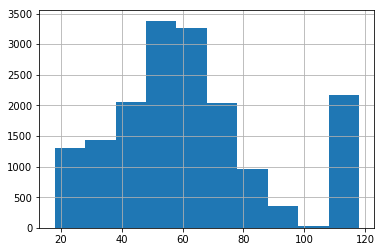

In [8]:
profile['age'].hist()

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [11]:
transcript.shape

(306534, 4)

In [12]:
transcript['time'].max()

714

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Clean the data

### Creating offer abbreviation

In [14]:
offer_abbs = ['bogo1', 'bogo2', 'bogo3', 'bogo4','disc1','disc2','disc3','disc4','info1','info2']

portfolio =portfolio.sort_values('offer_type')
portfolio['offer_abb']= offer_abbs

In [15]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,offer_abb
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo2
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo3
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,bogo4
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,disc1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,disc2
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,disc3
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,disc4
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,info1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,info2


### Deleting the unrearestic age (118 years old) and no gender and no income in profile

In [16]:
# Filtering the data

print('Number of no gendar items:{}'.format(profile['gender'].isnull().sum()))
print('Number of no income items:{}'.format(profile['income'].isnull().sum()))
print('Number of 118 years old:{}'.format((profile['age']==118).sum()))

print('Number of no gendar & no income & 118 years old:{}'.format(((profile['gender'].isnull())&(profile['income'].isnull())&(profile['age']==118)).sum()))

Number of no gendar items:2175
Number of no income items:2175
Number of 118 years old:2175
Number of no gendar & no income & 118 years old:2175


In [17]:
# Delete the filtered data
profile = profile[~((profile['gender'].isnull())&(profile['income'].isnull())&(profile['age']==118))]

In [18]:
# Check the data
((profile['gender'].isnull())&(profile['income'].isnull())&(profile['age']==118)).sum()

0

In [19]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


### Change the categorical value in gender column into dummy variables

In [20]:
profile = pd.concat([profile.drop('gender', axis=1), pd.get_dummies(profile['gender'], prefix='gender', prefix_sep='_', drop_first=False)], axis=1)

In [21]:
profile.head()

,age,became_member_on,id,income,gender_F,gender_M,gender_O
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
3,75,20170509,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
5,68,20180426,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
8,65,20180209,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
12,58,20171111,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


### Creating new df including amount and person column from transaction df

In [22]:
# Create amount column
transcript['amount'] =transcript['value'].apply(lambda x: list(x.values())[0] if (list(x)[0]=='amount') else np.nan)

# Create new df
amount_df =transcript[['person', 'time', 'amount']]

# Delete Nan from amount column
amount_df =amount_df[amount_df['amount'].notnull()]

In [23]:
# Check NaN number
amount_df['amount'].isnull().sum()

0

### Creating new df including offer_abb and offer status columns and person-offer matrix

In [24]:
# Create offer id column
transcript['offer_id'] =transcript['value'].apply(lambda x: list(x.values())[0] if ((list(x)[0]=='offer_id') or (list(x)[0]=='offer id'))  else np.nan)

# Create reward column
transcript['reward'] =transcript['value'].apply(lambda x: list(x.values())[1] if (list(x)[0]=='offer_id')  else 0)


# Create new df
offer_df = transcript[['event', 'person', 'time', 'offer_id', 'reward']]

#Delete Nan from amount column
offer_df = offer_df[offer_df['offer_id'].notnull()]

# Create portfolio dict
keys = list(portfolio['id'].unique())
values = list(portfolio['offer_abb'].unique())
offer_dict =dict(zip(keys, values))

# Create offer abbreviation column
offer_df['offer_abb'] = offer_df['offer_id'].apply(lambda x: offer_dict[x])

# Delete offer id column
offer_df = offer_df[['event', 'person', 'time', 'offer_abb', 'reward']]

In [25]:
# Create cost for reward column
# I assumpt that cost rate per one drink is 0.262 based on Starbycks P/L.
# bogo -> reward*0.262
# discount -> reward

bogo_row=offer_df['offer_abb'].str.contains('bogo')
disc_row=offer_df['offer_abb'].str.contains('disc')

offer_df.loc[bogo_row, 'rewarded_cost']  =offer_df[bogo_row]['reward']*0.262
offer_df.loc[disc_row, 'rewarded_cost']  =offer_df[disc_row]['reward']

In [26]:
offer_df.head()

,event,person,time,offer_abb,reward,rewarded_cost
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,bogo3,0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,disc1,0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,disc4,0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,disc3,0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,bogo2,0,0.0


In [27]:
offer_df.head()

,event,person,time,offer_abb,reward,rewarded_cost
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,bogo3,0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,disc1,0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,disc4,0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,disc3,0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,bogo2,0,0.0


In [28]:
cat_cols_lst = ['event', 'offer_abb']

for col in cat_cols_lst:
    # for each cat add dummy var, drop original column
    offer_df = pd.concat([offer_df.drop(col, axis=1), pd.get_dummies(offer_df[col], drop_first=False)], axis=1)

In [29]:
offer_df.head()

,person,time,reward,rewarded_cost,offer completed,offer received,offer viewed,bogo1,bogo2,bogo3,bogo4,disc1,disc2,disc3,disc4,info1,info2
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0


### Merge profile df into offer df

In [30]:
offer_matrix =pd.merge(offer_df, profile, left_on='person', right_on='id', how='left')

In [31]:
offer_matrix =offer_matrix.drop('id', axis=1)

In [32]:
offer_matrix =offer_matrix[offer_matrix['age'].notnull()]

In [33]:
offer_matrix.isnull().sum()

person                  0
time                    0
reward                  0
rewarded_cost       22660
offer completed         0
offer received          0
offer viewed            0
bogo1                   0
bogo2                   0
bogo3                   0
bogo4                   0
disc1                   0
disc2                   0
disc3                   0
disc4                   0
info1                   0
info2                   0
age                     0
became_member_on        0
income                  0
gender_F                0
gender_M                0
gender_O                0
dtype: int64

In [34]:
offer_matrix.head()

,person,time,reward,rewarded_cost,offer completed,offer received,offer viewed,bogo1,bogo2,bogo3,...,disc3,disc4,info1,info2,age,became_member_on,income,gender_F,gender_M,gender_O
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0,1,0,0,0,1,...,0,0,0,0,75.0,20170509.0,100000.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,0.0,0,1,0,0,0,0,...,0,1,0,0,68.0,20180426.0,70000.0,0.0,1.0,0.0
5,389bc3fa690240e798340f5a15918d5c,0,0,0.0,0,1,0,0,0,0,...,0,0,0,0,65.0,20180209.0,53000.0,0.0,1.0,0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,0,NaN,0,1,0,0,0,0,...,0,0,1,0,58.0,20171111.0,51000.0,0.0,1.0,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0,0.0,0,1,0,0,0,0,...,0,0,0,0,61.0,20170911.0,57000.0,1.0,0.0,0.0


### Checking Offer Received, Viewed and completed time

In [35]:
time_df =pd.DataFrame(offer_df.groupby('time')[['offer received', 'offer viewed', 'offer completed']].sum())

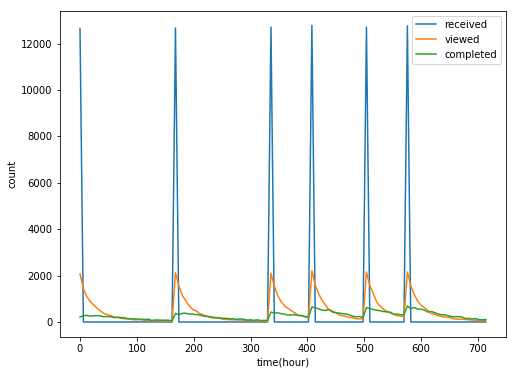

In [36]:
plt.figure(figsize=(8, 6))
p1 = plt.plot(time_df.index, time_df['offer received']);
p2 = plt.plot(time_df.index, time_df['offer viewed']);
p3 = plt.plot(time_df.index, time_df['offer completed'])
plt.xlabel('time(hour)');
plt.ylabel('count');
plt.legend((p1[0], p2[0], p3[0]), ('received', 'viewed', 'completed'), loc=1);

In [37]:
time_df[time_df['offer received']!=0]

,offer received,offer viewed,offer completed
time,,,
0,12650.0,2072.0,206.0
168,12669.0,2120.0,367.0
336,12711.0,2103.0,428.0
408,12778.0,2210.0,647.0
504,12704.0,2153.0,614.0
576,12765.0,2152.0,690.0


In [38]:
time_df[time_df['offer viewed']!=0].tail()

,offer received,offer viewed,offer completed
time,,,
690,0.0,87.0,130.0
696,0.0,74.0,148.0
702,0.0,59.0,101.0
708,0.0,57.0,99.0
714,0.0,50.0,103.0


- The offer was sent regularly once per 3~5days. The last offer was sent at 576 hours.
- The last offer was viewed and completed at 714 hours.
- After sending the last offer, it takes 5.75 days (714-576)/24 to finish the research. 
- Just after the offer was sent, the offer viewed and completed was increased.  
-> As the offer viewed and completed was decreased at 714 hours(the last hour), I decided not to drop any datas.

### Create profile_df with total amount, total reward, person profile and unique portfolio

In [39]:
# Total up the portfolio from offer  viewed data
offer_unique = pd.DataFrame((offer_df[offer_df['offer viewed']>0]).groupby('person')
                            ['bogo1', 'bogo2', 'bogo3', 'bogo4','disc1', 'disc2','disc3', 'disc4', 'info1', 'info2'].sum())

# Total up the reward from offer completed data
# (As info doesn't have '')
reward = pd.DataFrame(offer_df[offer_df['offer completed']>0].groupby('person')['reward', 'rewarded_cost'].sum())

# Merge the amount df, profie_df, offer_unique and reward.
profile_df = pd.merge(reward, offer_unique, on='person')
profile_df = pd.merge(profile, profile_df, left_on='id', right_on='person')
profile_df = pd.merge(profile_df, amount_df, left_on='id', right_on='person')

# Drop the duplicated column etc
profile_df.drop(['became_member_on', 'person', 'time'], axis=1, inplace=True)

# Check the profile df
profile_df.head()

,age,id,income,gender_F,gender_M,gender_O,reward,rewarded_cost,bogo1,bogo2,bogo3,bogo4,disc1,disc2,disc3,disc4,info1,info2,amount
0,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,20,5.24,1,0,1,1,0,0,0,0,0,1,19.89
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,20,5.24,1,0,1,1,0,0,0,0,0,1,17.78
2,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,20,5.24,1,0,1,1,0,0,0,0,0,1,19.67
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,20,5.24,1,0,1,1,0,0,0,0,0,1,29.72
4,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,20,5.24,1,0,1,1,0,0,0,0,0,1,23.93


In [40]:
profile_df.isnull().sum()

age              0
id               0
income           0
gender_F         0
gender_M         0
gender_O         0
reward           0
rewarded_cost    0
bogo1            0
bogo2            0
bogo3            0
bogo4            0
disc1            0
disc2            0
disc3            0
disc4            0
info1            0
info2            0
amount           0
dtype: int64

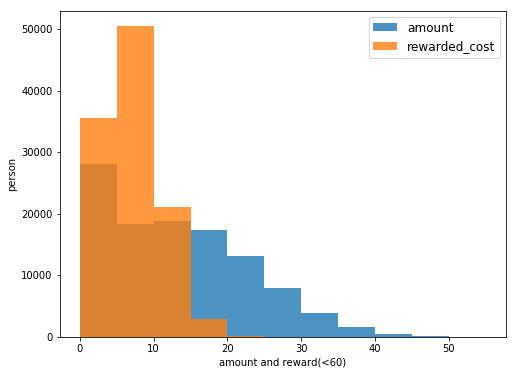

In [41]:
bins = np.arange(0, 60, 5)
plt.figure(figsize = [8,6])
amount=plt.hist(profile_df[profile_df['amount']<100]['amount'], bins=bins, alpha=0.8);
reward=plt.hist(profile_df['rewarded_cost'], bins=bins, alpha=0.8);
plt.xlabel('amount and reward(<60)');
plt.ylabel('person')
#plt.legend(loc=2, ncol=2)
plt.legend(('amount', 'rewarded_cost'), loc=1, fontsize=12, frameon=True)
plt.show();

## Question

### How to improve view rate

#### Comparing the view rate between bogo1 and bogo2
Bogo1 is more attractive offer than bogo2, because of same difficulty and reward and longer duration.  
But bogo1 isn't sent via **web**. 
If the bogo2 view rate is larger than one of bogo1, we can't reject the web channel is meaningless.

In [42]:
# Checking bogo1 and bogo2 view rate
bogo1_view_rate =((offer_df["offer viewed"]>0)&(offer_df["bogo1"]>0)).sum()/((offer_df["offer received"]>0)&(offer_df["bogo1"]>0)).sum()
bogo2_view_rate = ((offer_df["offer viewed"]>0)&(offer_df["bogo2"]>0)).sum()/((offer_df["offer received"]>0)&(offer_df["bogo2"]>0)).sum()
bogo1_2_view_rate = ((offer_df["offer viewed"]>0)&((offer_df["bogo1"]>0)|offer_df["bogo2"]>0)).sum()/((offer_df["offer received"]>0)&((offer_df["bogo1"]>0)|offer_df["bogo2"]>0)).sum()

print(('The bogo1 view rate: {}%').format(round(bogo1_view_rate*100,2)))
print(('The bogo2 view rate: {}%').format(round(bogo2_view_rate*100,2)))
print(('The bogo1&2 view rate: {}%').format(round(bogo1_2_view_rate*100,2)))

The bogo1 view rate: 87.7%
The bogo2 view rate: 96.11%
The bogo1&2 view rate: 91.89%


-> Bogo2 view rate is bigger than bogo1's. I'll check if the random sampling is implemented and calculate the p-value.  

p-value in age column: 0.8047
p-value in gender_M column: 0.9612
p-value in income column: 0.8555999999999999


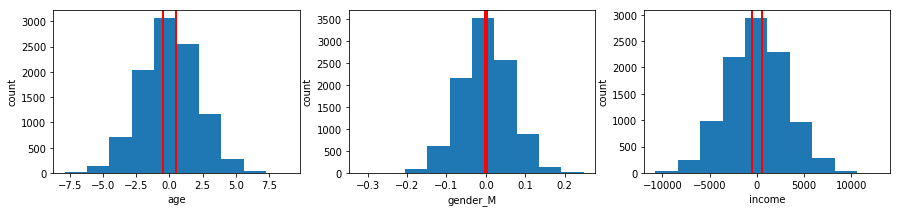

In [43]:
# Checking whether some columns have defferent result between bogo1 and bogo2
plt.figure(figsize = [15,3]) 
for i, col in enumerate(['age', 'gender_M', 'income']):
    p_diffs = []
    # Create the sample data and implemet bootstrapping
    for _ in range(100):
        sample_data = offer_matrix[(offer_matrix["bogo1"]>0)|(offer_matrix["bogo2"]>0)].sample(200, replace=True)
        sample_p_1 = sample_data[(sample_data["bogo1"]>0)][col].mean()
        sample_p_2 = sample_data[(sample_data["bogo2"]>0)][col].mean()
        sample_p_diff = sample_p_1 - sample_p_2
        p_diffs.append(sample_p_diff)
    p_diffs = np.array(p_diffs)
    # create the graph
    sample_mean = p_diffs.mean()
    null_vals = np.random.normal(0, np.std(p_diffs), 10000)
    plt.subplot(1, 3, i+1)
    plt.hist(null_vals)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.axvline(x=abs(sample_mean), color='red', linewidth=2)
    plt.axvline(x=-abs(sample_mean), color='red', linewidth=2)
    # calculate the p-value
    pvalue=(null_vals < -abs(sample_mean)).mean() + (null_vals > abs(sample_mean)).mean()
    print(('p-value in {} column: {}').format(col, pvalue))

As the all p-value is large enough, we can't reject that we don't have dviation between bogo1 and bogo2 group in age, gender and income columns.

p-value:0.0


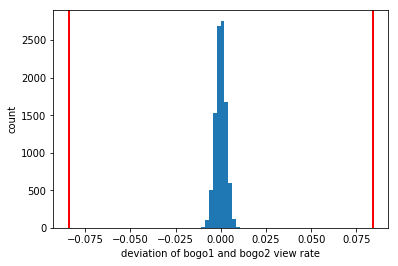

In [44]:
# Checking the deviation between bogo1 and bogo2 view rate
# get number of trials and view rate under bogo1
n_control =offer_df[(offer_df["bogo1"]>0)].shape[0]
n_exper =offer_df[(offer_df["bogo2"]>0)].shape[0]

# compute standard error, z-score, and p-value
se_p = np.sqrt(bogo1_2_view_rate * (1-bogo1_2_view_rate) * (1/n_control + 1/n_exper))
z = (bogo2_view_rate - bogo1_view_rate) / se_p
print('p-value:{}'.format((1-stats.norm.cdf(z))*2))

# plot the normal distribution and sample_means
sample_mean = p_diffs.mean()
null_vals = np.random.normal(0, se_p, 10000)
plt.figure(figsize = [6,4])
plt.hist(null_vals)
plt.xlabel('deviation of bogo1 and bogo2 view rate')
plt.ylabel('count')
plt.axvline(x=abs(bogo2_view_rate - bogo1_view_rate), color='red', linewidth=2)
plt.axvline(x=-abs(bogo2_view_rate - bogo1_view_rate), color='red', linewidth=2);

As the p-value is small enough, we can reject that we don't have dviation between bogo1 and bogo2 view rate.  
It means that **web-channel is effective to improve the offer view rate.**

#### Comparing the view rate between bogo3 and bogo4
Bogo3 is more attractive offer than bogo4, because of same difficulty and reward and longer duration.  
But bogo3 isn't sent via **social**. 
If the bogo3 view rate is larger than one of bogo4, we can't reject the social channel is meaningless.

In [45]:
# Checking bogo1 and bogo2 view rate
bogo3_view_rate =((offer_df["offer viewed"]>0)&(offer_df["bogo3"]>0)).sum()/((offer_df["offer received"]>0)&(offer_df["bogo3"]>0)).sum()
bogo4_view_rate = ((offer_df["offer viewed"]>0)&(offer_df["bogo4"]>0)).sum()/((offer_df["offer received"]>0)&(offer_df["bogo4"]>0)).sum()
bogo3_4_view_rate = ((offer_df["offer viewed"]>0)&((offer_df["bogo3"]>0)|offer_df["bogo4"]>0)).sum()/((offer_df["offer received"]>0)&((offer_df["bogo3"]>0)|offer_df["bogo4"]>0)).sum()

print(('The bogo3 view rate: {}%').format(round(bogo3_view_rate*100,2)))
print(('The bogo4 view rate: {}%').format(round(bogo4_view_rate*100,2)))
print(('The bogo3&4 view rate: {}%').format(round(bogo3_4_view_rate*100,2)))

The bogo3 view rate: 54.33%
The bogo4 view rate: 95.95%
The bogo3&4 view rate: 74.99%


-> Bogo4 view rate is bigger than bogo3's. I'll check if the random sampling is implemented and calculate the p-value.  

p-value in age column: 0.9832
p-value in gender_M column: 0.8711
p-value in income column: 0.992


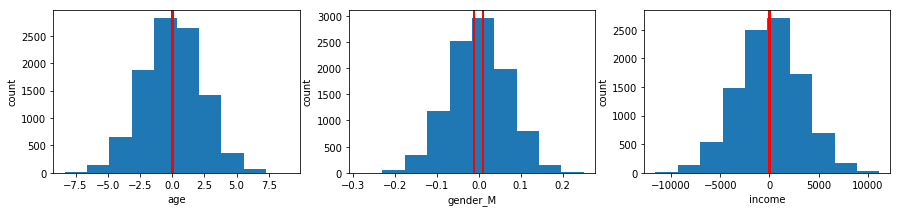

In [46]:
# Checking whether some columns have defferent result between bogo1 and bogo2
plt.figure(figsize = [15,3]) 
for i, col in enumerate(['age', 'gender_M', 'income']):
    p_diffs = []
    # Create the sample data and implemet bootstrapping
    for _ in range(100):
        sample_data = offer_matrix[(offer_matrix["bogo3"]>0)|(offer_matrix["bogo4"]>0)].sample(200, replace=True)
        sample_p_3 = sample_data[(sample_data["bogo3"]>0)][col].mean()
        sample_p_4 = sample_data[(sample_data["bogo4"]>0)][col].mean()
        sample_p_diff = sample_p_3 - sample_p_4
        p_diffs.append(sample_p_diff)
    p_diffs = np.array(p_diffs)
    # create the graph
    sample_mean = p_diffs.mean()
    null_vals = np.random.normal(0, np.std(p_diffs), 10000)
    plt.subplot(1, 3, i+1)
    plt.hist(null_vals)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.axvline(x=abs(sample_mean), color='red', linewidth=2)
    plt.axvline(x=-abs(sample_mean), color='red', linewidth=2)
    # calculate the p-value
    pvalue=(null_vals < -abs(sample_mean)).mean() + (null_vals > abs(sample_mean)).mean()
    print(('p-value in {} column: {}').format(col, pvalue))

As the all p-value is large enough, we can't reject that we don't have dviation between bogo3 and bogo4 group in age, gender and income columns.

p-value:0.0


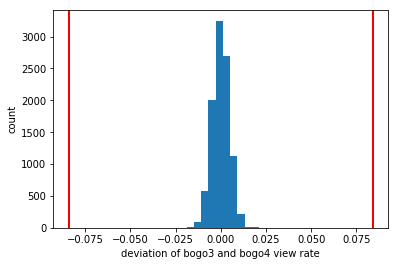

In [47]:
# Checking the deviation between bogo1 and bogo2 view rate
# get number of trials and view rate under bogo1
n_control =offer_df[(offer_df["bogo3"]>0)].shape[0]
n_exper =offer_df[(offer_df["bogo4"]>0)].shape[0]

# compute standard error, z-score, and p-value
se_p = np.sqrt(bogo3_4_view_rate * (1-bogo3_4_view_rate) * (1/n_control + 1/n_exper))
z = (bogo2_view_rate - bogo1_view_rate) / se_p
print('p-value:{}'.format((1-stats.norm.cdf(z))*2))

# plot the normal distribution and sample_means
sample_mean = p_diffs.mean()
null_vals = np.random.normal(0, se_p, 10000)
plt.figure(figsize = [6,4])
plt.hist(null_vals)
plt.xlabel('deviation of bogo3 and bogo4 view rate')
plt.ylabel('count')
plt.axvline(x=abs(bogo2_view_rate - bogo1_view_rate), color='red', linewidth=2)
plt.axvline(x=-abs(bogo2_view_rate - bogo1_view_rate), color='red', linewidth=2);

As the p-value is small enough, we can reject that we don't have dviation between bogo1 and bogo2 view rate.  
It means that **social-channel is effective to improve the offer view rate.**

#### Check the relationship among the rates of offer completed, offer received and offer viewed

In [48]:
# create DataFrame to display offer overview
# create index and columns
offer_columns = offer_df.columns.tolist()[7:17]
indexs = offer_df.columns.tolist()[4:7]

# create data table for offer overview
datas=[]
row_list=[]
for row, i in zip(indexs, range(len(indexs))):
    i =[]
    for col in offer_columns:
        val =offer_df[offer_df[col]>0][row].sum()
        i.append(val)
    datas.append(i)

# create DataFrame for offer overview
offer_overview =pd.DataFrame(datas, columns=offer_columns, index=indexs)
offer_overview

,bogo1,bogo2,bogo3,bogo4,disc1,disc2,disc3,disc4,info1,info2
offer completed,3688,3331,4354,4296,3420,5156,5317,4017,0,0
offer received,7658,7593,7677,7571,7668,7646,7597,7632,7617,7618
offer viewed,6716,7298,4171,7264,2663,7337,7327,4118,4144,6687


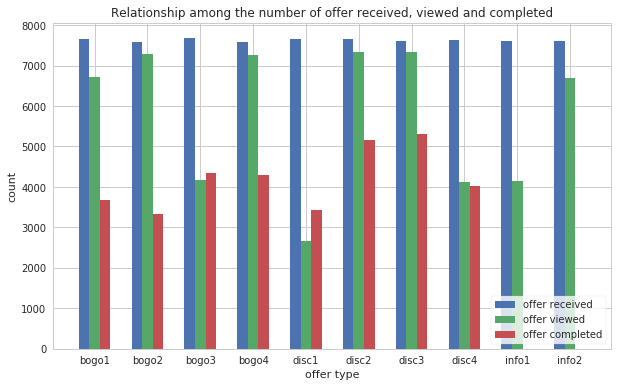

In [49]:
sb.set()
sb.set_style('whitegrid')

x = offer_columns
x_position = np.arange(len(x))

offer_received = np.array(offer_overview.loc['offer received',:])
offer_viewed = np.array(offer_overview.loc['offer viewed',:])
offer_completed = np.array(offer_overview.loc['offer completed',:])

fig = plt.figure(figsize = [10,6])
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, offer_received, width=0.2, label='offer received')
ax.bar(x_position + 0.2, offer_viewed, width=0.2, label='offer viewed')
ax.bar(x_position + 0.4, offer_completed, width=0.2, label='offer completed')
ax.legend(loc=4, frameon=True)
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(x)
plt.title('Relationship among the number of offer received, viewed and completed')
plt.ylabel('count')
plt.xlabel('offer type')
plt.show()

-> In bogo3 and disc1, the number of offer completed is bigger than one of offer viewed.  
Considering the workflow, it's imposible. We need to check whether some datas is missing or not.

### How to improve profitability
Asumption:
- profit per customer = sales*(1-0.262) - rewarded_cost 
(I assumpt that cost rate per one drink is 0.262 based on Starbycks P/L.) 
  
Purpose:
- To maximize the profit per customer
-> I estimated the profit per customer with sklearn LinearRegression model.

#### Implement the prediction with whole profit

In [50]:
# set the profit column following above assumption

profile_df['profit'] = profile_df['amount']*(1-0.262) - profile_df['rewarded_cost']

In [51]:
profile_df['profit'].mean()

4.1357660225808202

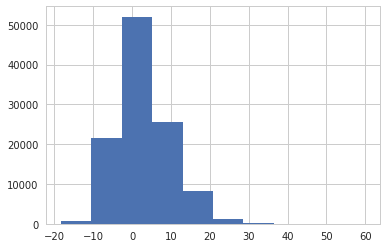

In [52]:
plt.hist(profile_df[profile_df['profit']<60]['profit']);

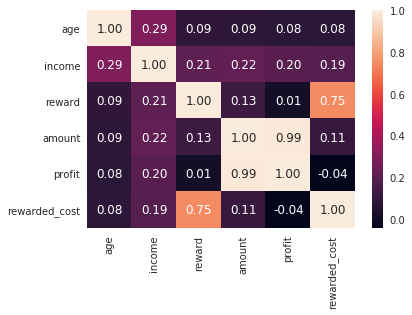

In [53]:
# Check the correlation among the float variables
sb.heatmap(profile_df[['age','income','reward','amount','profit','rewarded_cost']].corr(), annot=True, fmt=".2f");

-> As we have strong colleration between amount and profit, I decided to delete amount in sklearn LinearRegression model.  
-> As we have strong colleration between rewarded_cost and reward, I decided to delete reward in sklearn LinearRegression model.

In [54]:
# set X and y
y = profile_df['profit']
X = profile_df.drop(['id', 'amount','profit', 'reward'], axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=40)

In [56]:
# Cell for your computations to answer the next question
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds =lm_model.predict(X_test)  
y_train_preds =lm_model.predict(X_train)

test_score= r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(test_score)
print(train_score)

0.047394824063
0.0483009124801


-> As the r2 score is too low, I'll consider how I should set the model 

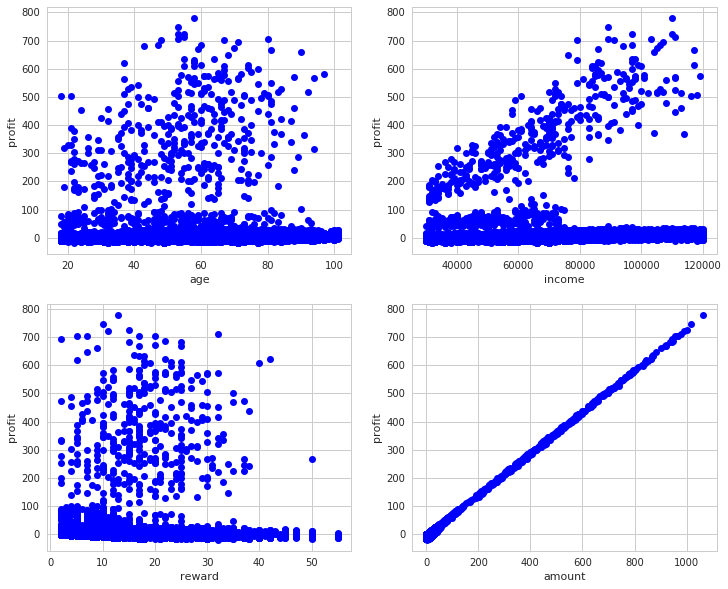

In [57]:
fig = plt.figure(figsize=(12,10))
plt.title('Relationship between Profit and each float variables')
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0))
ax4 = plt.subplot2grid((2,2), (1,1))

ax1.plot(profile_df['age'], profile_df['profit'],"bo" )
ax1.set_xlabel('age')
ax1.set_ylabel('profit')

ax2.plot(profile_df['income'], profile_df['profit'],"bo" )
ax2.set_xlabel('income')
ax2.set_ylabel('profit')

ax3.plot(profile_df['reward'], profile_df['profit'],"bo" )
ax3.set_xlabel('reward')
ax3.set_ylabel('profit')

ax4.plot(profile_df['amount'], profile_df['profit'],"bo" )
ax4.set_xlabel('amount')
ax4.set_ylabel('profit');

-> I think we have main 2 group. One profitability is below 100, the other is over 100.

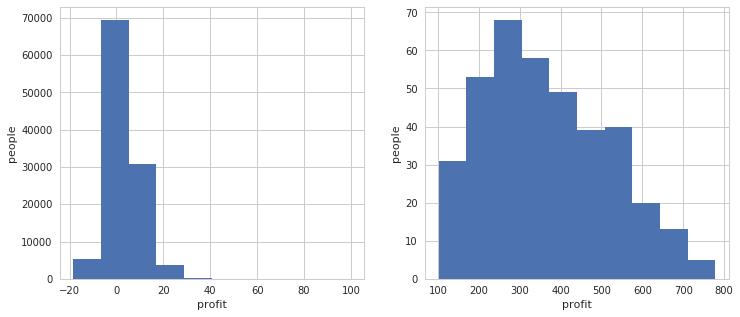

In [58]:
plt.figure(figsize = [12,5])
plt.title('splitted histgram by profit=100')

plt.subplot(1,2,1)
profile_df[profile_df['profit']<100]['profit'].hist()
plt.xlabel('profit')
plt.ylabel('people')

plt.subplot(1,2,2)
profile_df[profile_df['profit']>=100]['profit'].hist()
plt.xlabel('profit')
plt.ylabel('people');

#### Implement the prediction with the profit <100

In [59]:
# set the DataFrame with profit <100
low_profit =profile_df[profile_df['profit']<100]

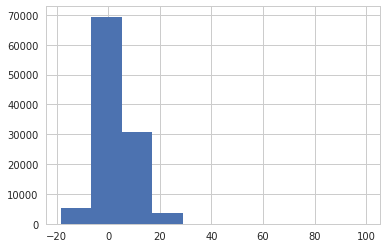

In [60]:
profile_df[profile_df['profit']<100]['profit'].hist()

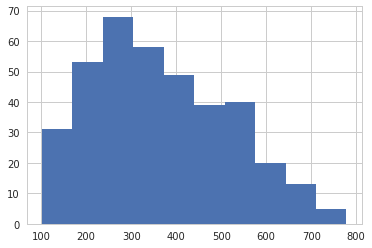

In [61]:
profile_df[profile_df['profit']>100]['profit'].hist()

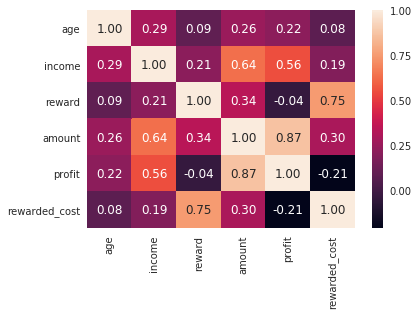

In [62]:
# Check the correlation among the float variables
sb.heatmap(low_profit[['age','income','reward','amount','profit', 'rewarded_cost']].corr(), annot=True, fmt=".2f");

-> As we have strong colleration between rewarded_cost and reward, I decided to delete reward in sklearn LinearRegression model.

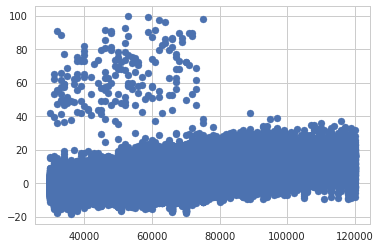

In [63]:
plt.scatter(low_profit['income'], low_profit['profit']);

In [82]:
# set X and y
y = low_profit['profit']
X = low_profit.drop(['id', 'profit', 'reward', 'amount', 'gender_O', 'rewarded_cost'], axis=1)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=40)

In [84]:
# Cell for your computations to answer the next question
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds =lm_model.predict(X_test)  
y_train_preds =lm_model.predict(X_train)

test_score= r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(test_score)
print(train_score)

0.386926196907
0.389875503534


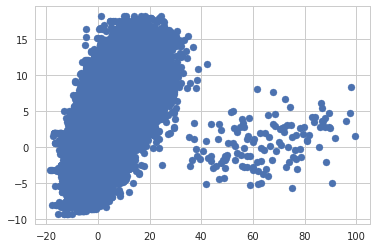

In [85]:
plt.scatter(y_train, y_train_preds);

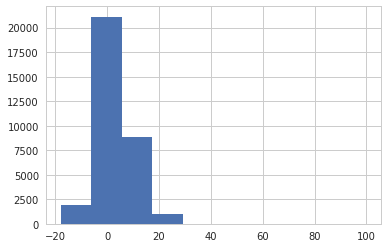

In [86]:
y_test.hist();

In [87]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
8,disc1,-2.577645,2.577645
9,disc2,-2.058927,2.058927
10,disc3,-1.206619,1.206619
4,bogo1,-1.180442,1.180442
12,info1,1.085624,1.085624
5,bogo2,-0.939293,0.939293
3,gender_M,-0.915016,0.915016
11,disc4,-0.737139,0.737139
13,info2,0.711504,0.711504
7,bogo4,-0.340844,0.340844


-> In the low profit group, all discount and bogo have negative or small positive coefficient.

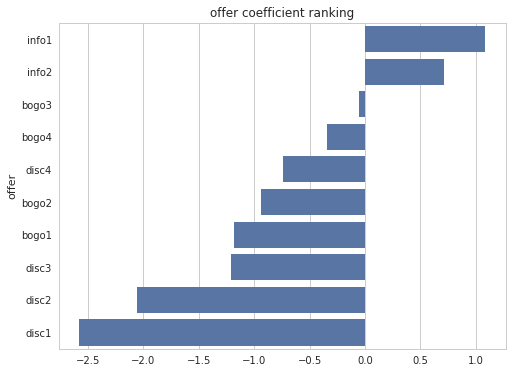

In [100]:
graph_df = coef_df[coef_df['est_int'].isin(offer_abbs)].sort_values('coefs', ascending=False)
plt.figure(figsize = [8,6])
base_color = sb.color_palette()[0]
sb.barplot(data=graph_df, y='est_int', x='coefs', color=base_color)
plt.xlabel('')
plt.ylabel('offer')
plt.title('offer coefficient ranking');

#### Implement the prediction with the profit >=100

In [102]:
# set the DataFrame with profit >=100
high_profit =profile_df[profile_df['profit']>=100]

In [103]:
high_profit.shape

(376, 20)

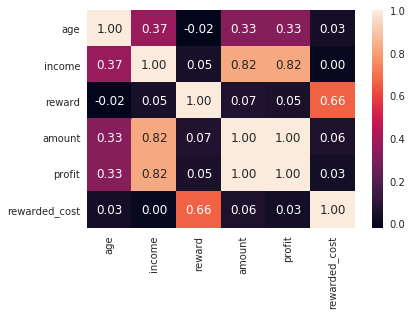

In [104]:
# Check the correlation among the float variables
sb.heatmap(high_profit[['age','income','reward','amount','profit', 'rewarded_cost']].corr(), annot=True, fmt=".2f");

-> As we have strong colleration between reward and rewarded cost, I decided to delete both in sklearn LinearRegression model.

In [105]:
# set X and y
y = high_profit['profit']
X = high_profit.drop(['id', 'profit', 'reward', 'amount', 'gender_O'], axis=1)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=41)

In [107]:
# Cell for your computations to answer the next question
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds =lm_model.predict(X_test)  
y_train_preds =lm_model.predict(X_train)

test_score= r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(test_score)
print(train_score)

0.624803830423
0.699042638071


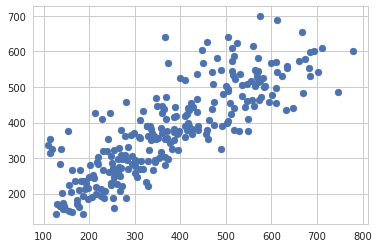

In [108]:
plt.scatter(y_train, y_train_preds);

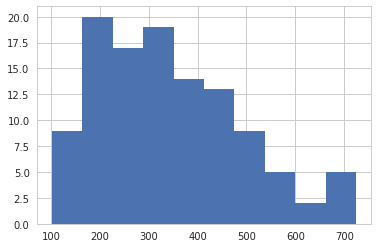

In [109]:
y_test.hist();

In [110]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
10,disc2,-21.122224,21.122224
6,bogo2,-19.592453,19.592453
2,gender_F,13.840558,13.840558
11,disc3,-12.062964,12.062964
7,bogo3,-8.516737,8.516737
5,bogo1,-8.200483,8.200483
8,bogo4,-7.446710,7.446710
14,info2,-6.854208,6.854208
9,disc1,6.676695,6.676695
4,rewarded_cost,3.933615,3.933615


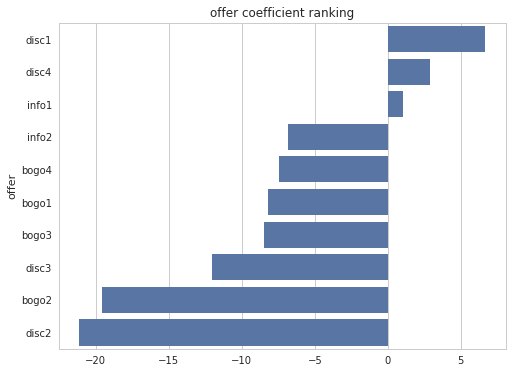

In [111]:
graph_df = coef_df[coef_df['est_int'].isin(offer_abbs)].sort_values('coefs', ascending=False)
plt.figure(figsize = [8,6])
base_color = sb.color_palette()[0]
sb.barplot(data=graph_df, y='est_int', x='coefs', color=base_color)
plt.xlabel('')
plt.ylabel('offer')
plt.title('offer coefficient ranking');

-> all discount and bogo have negative or small positive coefficient in the high profit group.  
-> In the high profit group, we have strong correlation between income and profit.